In [1]:
import rpy2
print(rpy2.__version__)
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
%load_ext rpy2.ipython


import numpy as np
from scipy import sparse

2.9.4


In [2]:
seurat = importr('Seurat')

In [3]:
pbmc_data = seurat.Read10X(data_dir = 'filtered_gene_bc_matrices/hg19/')
pbmc = seurat.CreateSeuratObject(raw_data = pbmc_data, min_cells = 3, min_genes = 200, project = "10X_PBMC")

In [4]:
%%R -i pbmc -o percent_mito
# This cell does some preprocessing which we could do in python as well, but it'd be convoluted to change all the objects back and forth
mito.genes <- grep(pattern = "^MT-", x = rownames(x = pbmc@data), value = TRUE)
percent_mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ])/Matrix::colSums(pbmc@raw.data)

In [5]:
pbmc = seurat.AddMetaData(object = pbmc, metadata = percent_mito, col_name = "percent.mito")

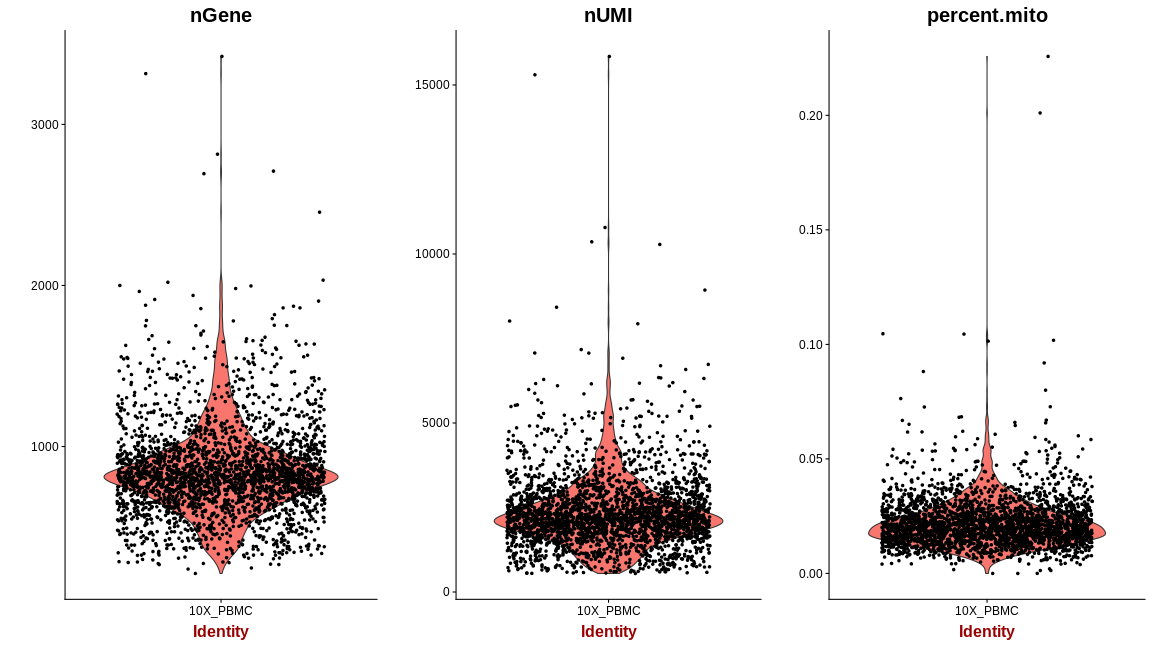

In [6]:
%%R -i pbmc -w 16 -h 9 -u in
VlnPlot(object = pbmc, features.plot = c("nGene", "nUMI", "percent.mito"), nCol = 3)

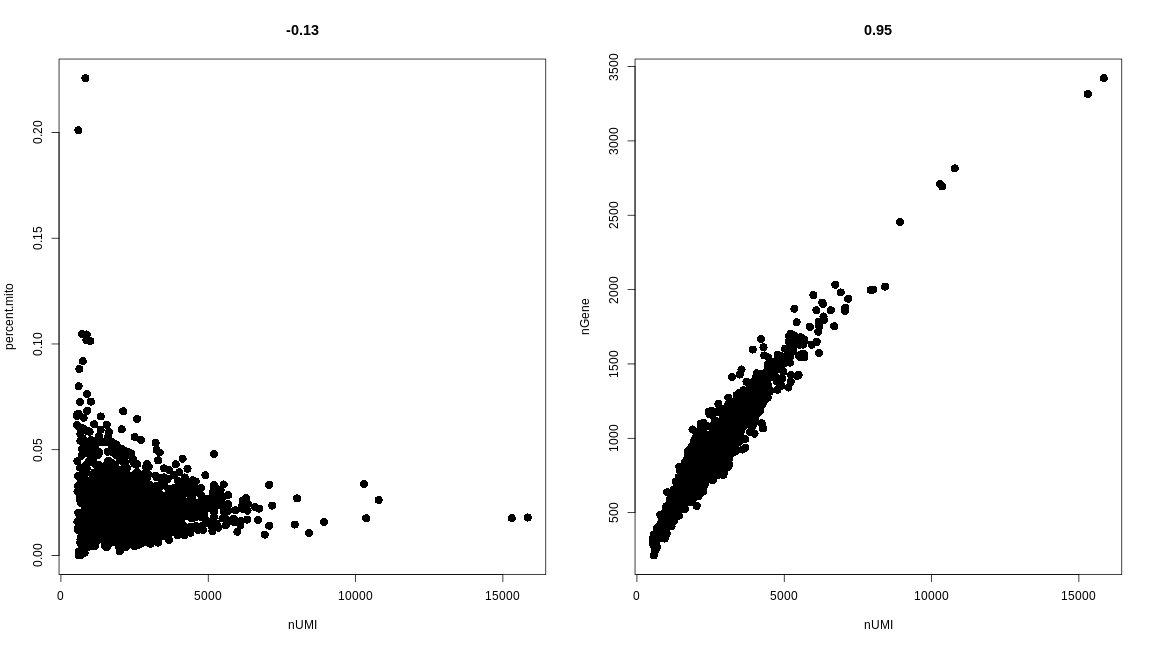

In [7]:
%%R -i pbmc -w 16 -h 9 -u in
# GenePlot is typically used to visualize gene-gene relationships, but can
# be used for anything calculated by the object, i.e. columns in
# object@meta.data, PC scores etc.  Since there is a rare subset of cells
# with an outlier level of high mitochondrial percentage and also low UMI
# content, we filter these as well
par(mfrow = c(1, 2))
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "percent.mito")
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "nGene")

In [8]:
%%R -i pbmc -o pbmc
# We filter out cells that have unique gene counts over 2,500 or less than
# 200 Note that low.thresholds and high.thresholds are used to define a
# 'gate'.  -Inf and Inf should be used if you don't want a lower or upper
# threshold.
pbmc <- FilterCells(object = pbmc, subset.names = c("nGene", "percent.mito"), low.thresholds = c(200, -Inf), high.thresholds = c(2500, 0.05))

In [9]:
%%R -i pbmc -o pbmc
pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
#seurat.NormalizeData(object = pbmc, normalization_method = "LogNormalize", scale_factor = 10000)

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Performing log-normalization

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 0%   10   20   30   40   50   60   70   80   90   100%

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: [----|----|----|----|----|----|----|----|----|----|

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: *
  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: |

  warnings.warn(x, RRuntimeWarning)


/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Calculating gene means
  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Calculating gene variance to mean ratios
  warnings.warn(x, RRuntimeWarning)


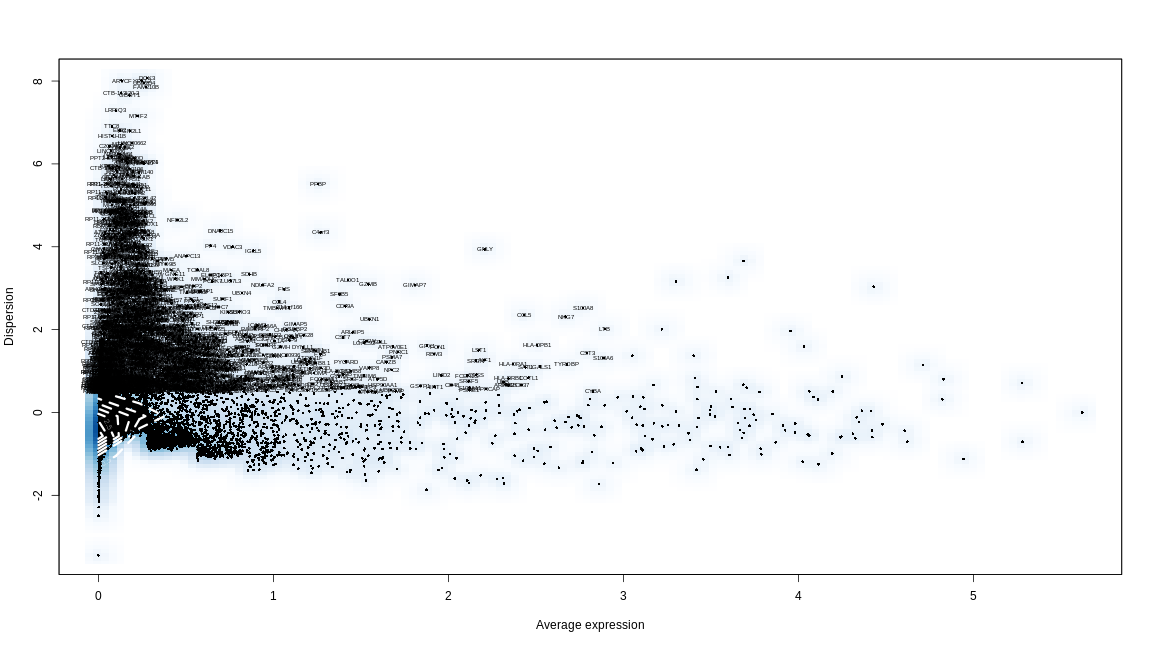

In [10]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
pbmc <- FindVariableGenes(object = pbmc, mean.function = ExpMean, dispersion.function = LogVMR, 
x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)

In [11]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
pbmc <- ScaleData(object = pbmc, vars.to.regress = c("nUMI", "percent.mito"))

/opt/conda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Regressing out: nUMI, percent.mito

  warnings.warn(x, RRuntimeWarning)
  |                                                                            eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |                                                                      |   0%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=                                                                     |   1%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==                                                                    |   2%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==                                                                    |   3%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===                                                                   |   4%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |====                                                                  |   5%eWar

  |=======================================                               |  56%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |========================================                              |  57%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=========================================                             |  58%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |=========================================                             |  59%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==========================================                            |  59%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |==========================================                            |  60%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===========================================                           |  61%eWarning: 
  warnings.warn(x, RRuntimeWarning)
  |===========================================                           |  62%eWarning: 
  warnings.warn(x, RRuntimeW


Time Elapsed:  35.5978305339813 secs

In [12]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
pbmc <- RunPCA(object = pbmc, pc.genes = pbmc@var.genes, do.print = TRUE, pcs.print = 1:5, 
    genes.print = 5)

[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] ""
[1] "PC3"
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] ""
[1] "PC4"
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] ""
[1] "PC5"
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] ""


In [13]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
# Examine and visualize PCA results a few different ways
PrintPCA(object = pbmc, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] ""
[1] "PC3"
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] ""
[1] "PC4"
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] ""
[1] "PC5"
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] ""


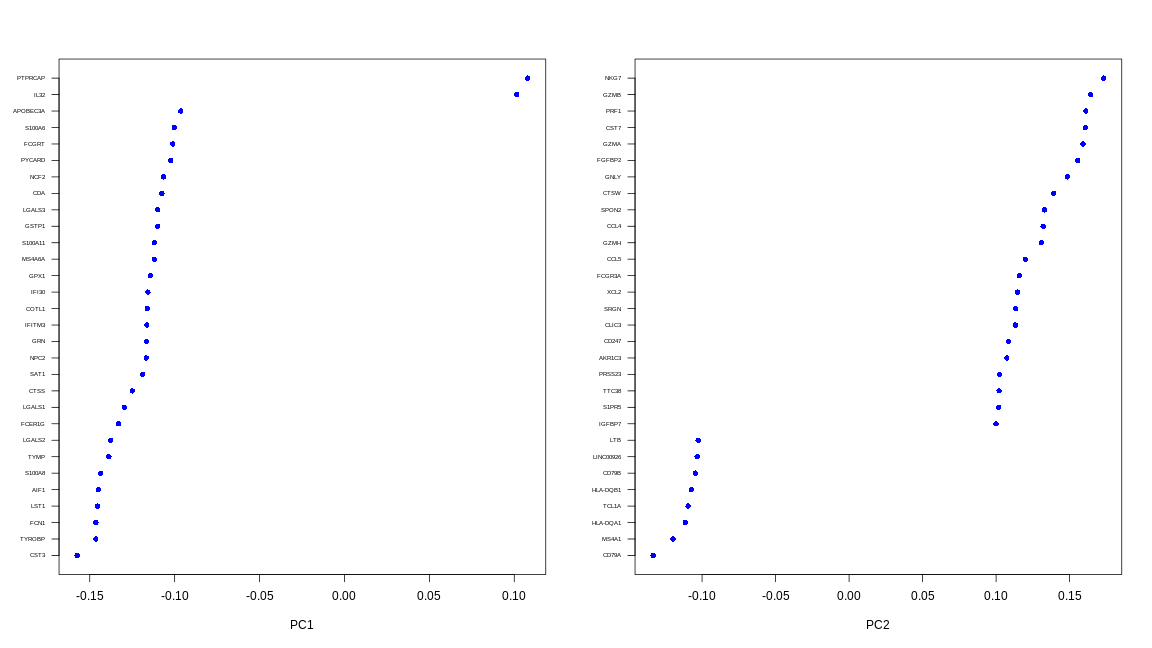

In [14]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
VizPCA(object = pbmc, pcs.use = 1:2)

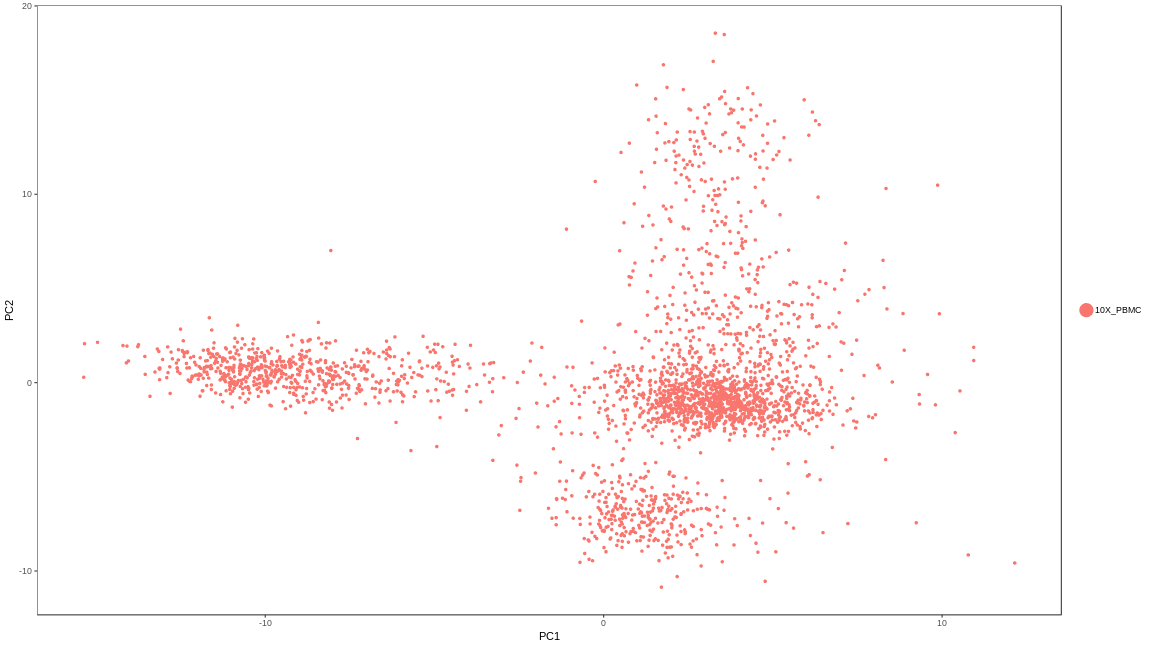

In [15]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
PCAPlot(object = pbmc, dim.1 = 1, dim.2 = 2)

In [16]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
# ProjectPCA scores each gene in the dataset (including genes not included
# in the PCA) based on their correlation with the calculated components.
# Though we don't use this further here, it can be used to identify markers
# that are strongly correlated with cellular heterogeneity, but may not have
# passed through variable gene selection.  The results of the projected PCA
# can be explored by setting use.full=T in the functions above
pbmc <- ProjectPCA(object = pbmc, do.print = FALSE)

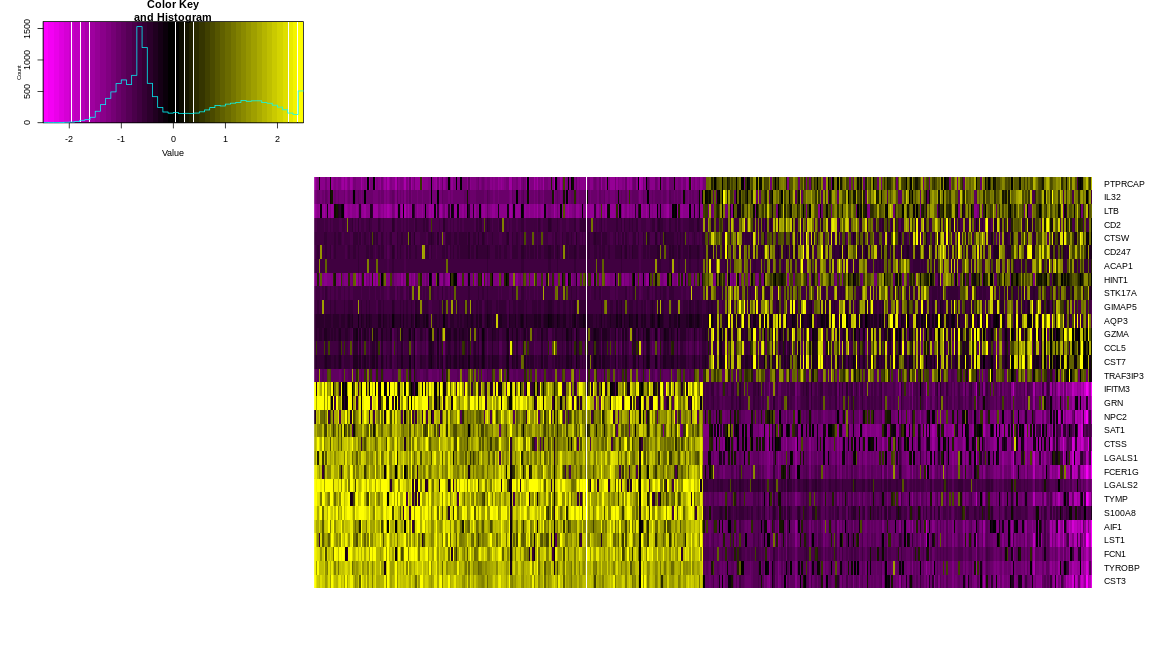

In [17]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
PCHeatmap(object = pbmc, pc.use = 1, cells.use = 500, do.balanced = TRUE, label.columns = FALSE)

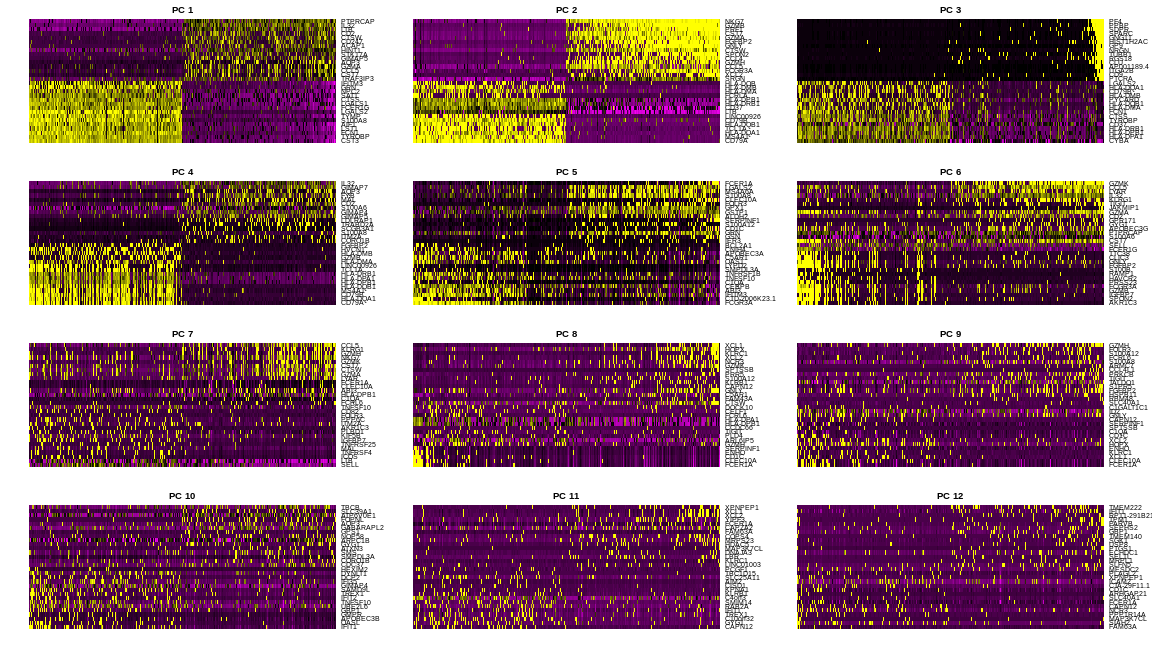

In [18]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
PCHeatmap(object = pbmc, pc.use = 1:12, cells.use = 500, do.balanced = TRUE, 
    label.columns = FALSE, use.full = FALSE)

In [19]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
# NOTE: This process can take a long time for big datasets, comment out for
# expediency.  More approximate techniques such as those implemented in
# PCElbowPlot() can be used to reduce computation time
pbmc <- JackStraw(object = pbmc, num.replicate = 100, display.progress = FALSE)

An object of class seurat in project 10X_PBMC 
 13714 genes across 2638 samples.


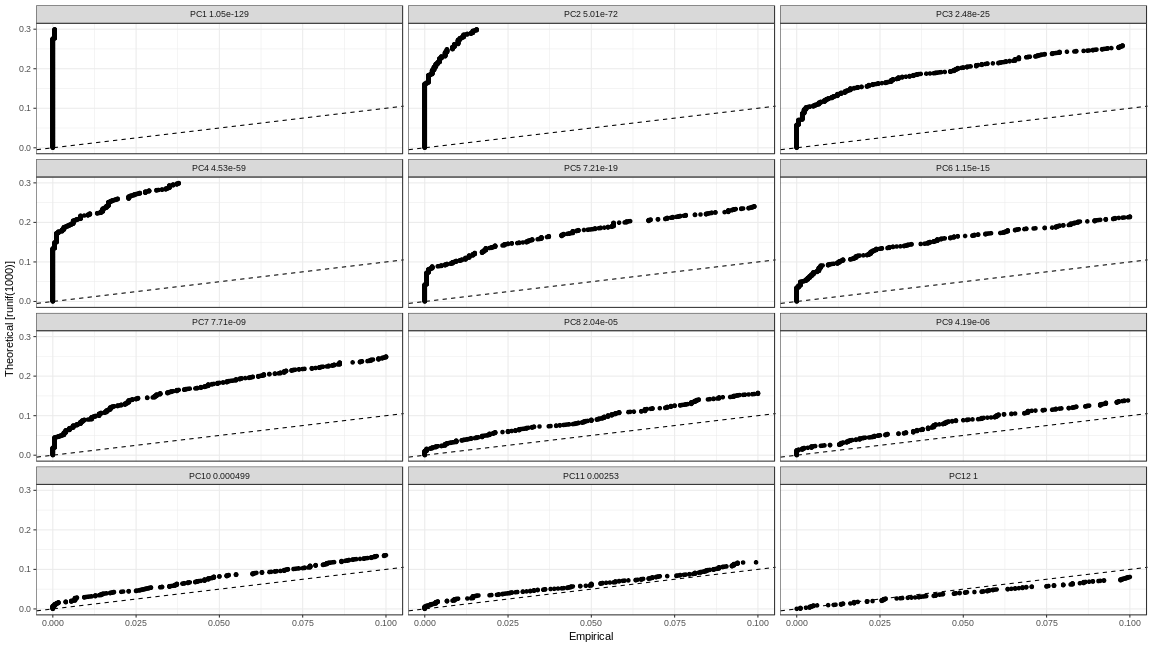

In [20]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
JackStrawPlot(object = pbmc, PCs = 1:12)

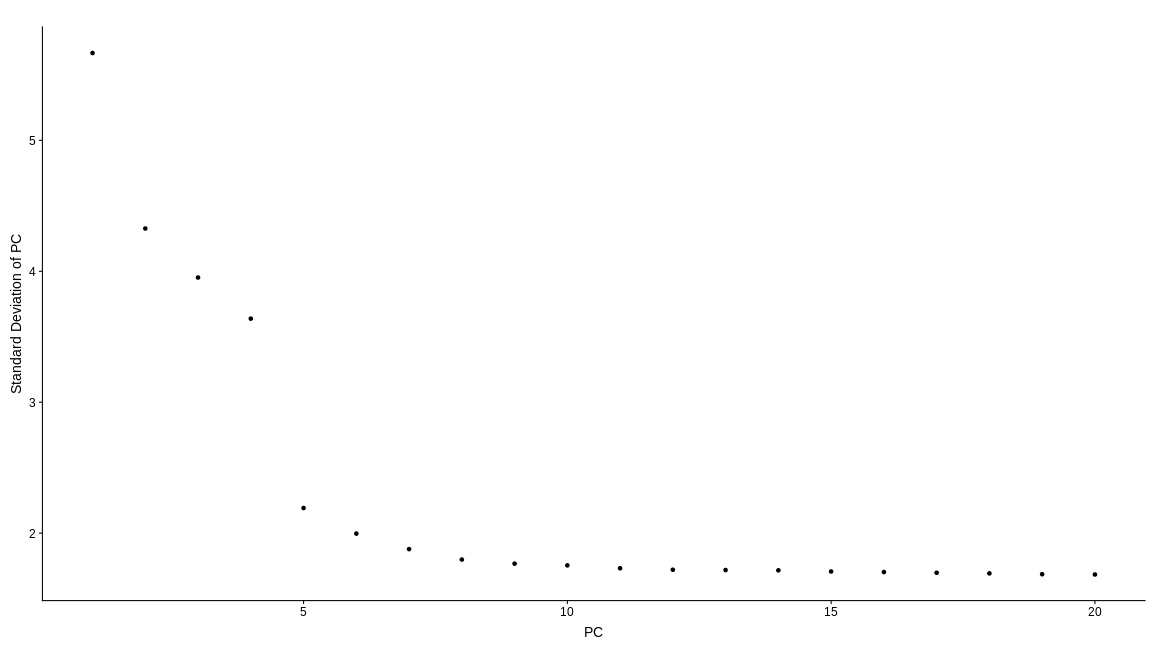

In [21]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
PCElbowPlot(object = pbmc)

In [22]:
%%R -i pbmc -o pbmc -w 16 -h 9 -u in
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun
# using the same graph but with a different resolution value (see docs for
# full details)
pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, 
    resolution = 0.6, print.output = 0, save.SNN = TRUE)